<div class="alert alert-block alert-info">
<b>Tip:</b> Start with no noise in your data. That way, if there are any problems, you will know it is not because of the noise.
</div>

<div class="alert alert-block alert-info">
    <b>Tip:</b> It might be easier to start with <tt>scipy.optimize.curvefit</tt>, because you only need to supply the fitting function. Then move to <tt>scipy.optimize.least_squares</tt>, where you need to supply the residuals and the Jacobian of the residuals.
    
When you have them working, that can be used as the basis for <tt>scipy.optimize.minimize</tt>.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Increase the number of data points to fit. 
    
For example, if you have 20 data points, and only 6 are in the gaussian peak, their influence on the parameter space will be minimal. You may use equally spaced data in the $x$ axis if you wish.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Note that the fitting the cosine function is very sensitive to a good inital guess for the frequency, and the gaussian function is a little sensitive to a good inital guess of the variance and position.
</div>

<div class="alert alert-block alert-info">
    <b>Tip:</b> You may not get <tt>scipy.optimize.minimize</tt> with <tt>Newton-CG</tt> to give you the really good fits you want; that's okay. Try your best to provide the correct Jacobian.
</div>

In [1]:
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Homework 13 - Nonlinear regression

Use **each** of the three solvers 
- `scipy.optimize.minimize`, 
- `scipy.optimize.least_squares` 
- **and** `scipy.optimize.curve_fit` 

to fit a multi-parameter function to example data. You may choose one of these model functions;

- Fourth order polynomial (a well behaved function, but more parameters)
$$
f(x;\vec{a}) = a_4x^4+a_3x^3+a_2x^2+a_1x+a_0
$$
- Gaussian function (the Jacobian is a bit messy)
$$
f(x;\vec{a}) = a_0e^{-((x-a_1)^2)/a_2}
$$
- Cosine function (fit is sensitive to frequency inital guess)
$$
f(x;\vec{a}) = a_0\cos(a_1x+a_2)
$$

- Construct *slightly* noisy data much like the lecutre notes. 

- For each fit, plot
   - the data you are fitting,
   - the true curve,
   - the fit. 

# Sympy
I was going to do this with SymPy so that I could create the Jacobian symbolically, but I decided not to as the Jacobian will be trivial for the quartic function I chose anyways.

In [2]:
# import sympy as sym

# x = sym.Symbol('x')
# a4, a3, a2, a1, a0 = sym.symbols('a4, a3, a2, a1, a0')
# f = a4*x**4 + a3*x**3 + a2*x**2 + a1*x + a0
# f.subs({a4: 0, a3: 0, a2: 0, a1: 0, a0: 0})

# Scipy Curve Fit

The fit parameters are:
Parameter 0 is 0.991+/-0.014 (Actual Value: 1)
Parameter 1 is 2.951+/-0.036 (Actual Value: 3)
Parameter 2 is -4.813+/-0.333 (Actual Value: -5)
Parameter 3 is 2.979+/-0.611 (Actual Value: 2)
Parameter 4 is -0.587+/-1.327 (Actual Value: 1)


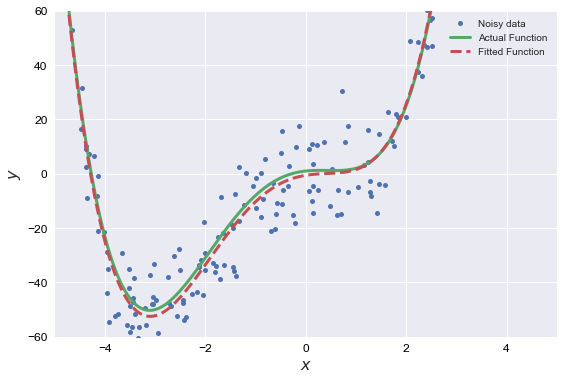

In [3]:
# Function
def f(x, *args):
    return sum(arg*x**(len(args) - i - 1) for i, arg in enumerate(args))

# Plot Range
xmin = -5
xmax = 5
n = 200

# True Data
params = (1, 3, -5, 2, 1)
xtrue = np.linspace(xmin, xmax, n)
ytrue = f(xtrue, *params)

# Create Noisy Data
sigma = 10
mu = 0.0
xnoise = np.random.random(n)*(xmax - xmin) + xmin
ynoise = f(xnoise, *params) + (sigma * np.random.randn((n)) + mu)

# Scipy Surve Fit
fit, cov = spo.curve_fit(
    f, 
    xnoise, 
    ynoise, 
    p0=list(
        0
        for _ in range(len(params))
    )
)
error = np.sqrt(np.diag(cov))

print(f"The fit parameters are:")
for i, param in enumerate(fit):
    print(f"Parameter {i} is {param:1.3f}+/-{error[i]:1.3f} (Actual Value: {params[i]})")


# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.tick_params(axis='both', which='major', labelsize=12, labelcolor="black", width=2)

ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"$y$", fontsize=16)

# Noisy Data
ax.plot(xnoise, ynoise,'.',markersize=10, label="Noisy data")

# True function
ax.plot(xtrue, ytrue,'-', linewidth=3, label="Actual Function")

# Scipy Curve Fit
ax.plot(xtrue, f(xtrue, *fit), '--', linewidth=3, label="Fitted Function")

ax.set_xlim(xmin, xmax)
ax.set_ylim(-60, 60)

plt.legend()
plt.show()
plt.close()

# Scipy Least Squares

Success: True
Message: `gtol` termination condition is satisfied.
Parameter 0 is 0.984+/-0.002 (Actual Value: 1)
Parameter 1 is 3.061+/-0.004 (Actual Value: 3)
Parameter 2 is -4.608+/-0.034 (Actual Value: -5)
Parameter 3 is 1.453+/-0.068 (Actual Value: 2)
Parameter 4 is 0.311+/-0.122 (Actual Value: 1)


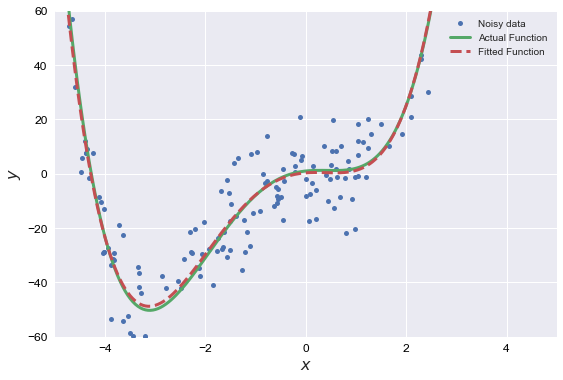

In [4]:
# Function
def f(x, *args):
    return sum(arg*x**(len(args) - i - 1) for i, arg in enumerate(args))

# Jacobian
def j(x, *args):
    return np.array(
            [x**(len(args) - i - 1) for i in range(len(args))]
    ).T

# F Residuals
def f_model(params, *data):
    return f(data[0], *params) - data[1]

# Jacobian Model
def j_model(params, *data):
    return j(data[0], *params)

# Plot Range
xmin = -5
xmax = 5
n = 200

# True Data
params = (1, 3, -5, 2, 1)
xtrue = np.linspace(xmin, xmax, n)
ytrue = f(xtrue, *params)

# Create Noisy Data
sigma = 10
mu = 0.0
xnoise = np.random.random(n)*(xmax - xmin) + xmin
ynoise = f(xnoise, *params) + (sigma * np.random.randn((n)) + mu)

# Scipy Curve Fit
params_initial = np.array([1 for _ in range(len(params))])
result = spo.least_squares(
    f_model,
    params_initial,
    method='lm',
    jac=j_model,
    args=(xnoise, ynoise)
)

yfit = f(xtrue, *result.x)
hessian = np.dot(result.jac.T, result.jac)
covariance = np.abs(np.linalg.inv(hessian))
error = np.sqrt(np.diagonal(covariance))

print(f"Success: {result.success}")
print(f"Message: {result.message}")
for i, param in enumerate(result.x):
    print(f"Parameter {i} is {param:1.3f}+/-{error[i]:1.3f} (Actual Value: {params[i]})")


# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.tick_params(axis='both', which='major', labelsize=12, labelcolor="black", width=2)

ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"$y$", fontsize=16)

# Noisy Data
ax.plot(xnoise, ynoise,'.',markersize=10, label="Noisy data")

# True function
ax.plot(xtrue, ytrue,'-', linewidth=3, label="Actual Function")

# Scipy Least Squares
ax.plot(xtrue, yfit, '--', linewidth=3, label="Fitted Function")

ax.set_xlim(xmin, xmax)
ax.set_ylim(-60, 60)

plt.legend()
plt.show()
plt.close()

# Scipy Minimize

Success: True
Message: Optimization terminated successfully.
Parameter 0 is 1.005+/-0.001 (Actual Value: 1)
Parameter 1 is 2.986+/-0.004 (Actual Value: 3)
Parameter 2 is -5.155+/-0.033 (Actual Value: -5)
Parameter 3 is 2.297+/-0.062 (Actual Value: 2)
Parameter 4 is 1.553+/-0.133 (Actual Value: 1)


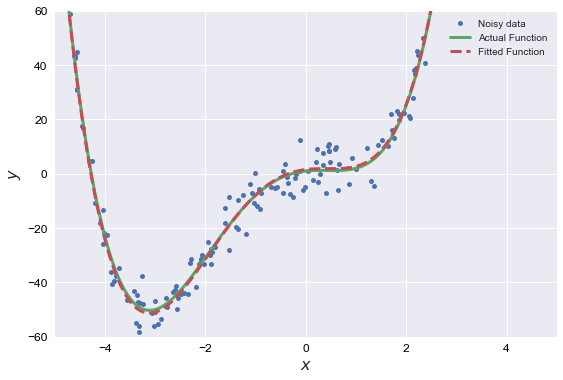

In [5]:
# Function
def f(x, *args):
    return sum(arg*x**(len(args) - i - 1) for i, arg in enumerate(args))

# Jacobian
def j(params, *data):
    return np.array(
            [data[0]**(len(params) - i - 1) for i in range(len(params))]
    ).T

# F Residuals Squared
def f_model(params, *data):
    return sum((f(data[0], *params) - data[1])**2)

# Jacobian Residuals
def j_model(params, *data):
    residual = np.array(f(data[0], *params) - data[1])
    # For some reason writing J this way doesn't work, even though it converges the exact same way
    # Not exactly sure as to why, but it works when I write it explicitly. 
    # J = np.array([sum(residual * j(params, *data)[:,i - 1]) for i in range(len(params))])
    J0 = sum(residual*data[0]**4)
    J1 = sum(residual*data[0]**3)
    J2 = sum(residual*data[0]**2)
    J3 = sum(residual*data[0])
    J4 = sum(residual)
    return np.array([J0, J1, J2, J3, J4])

# Plot Range
xmin = -5
xmax = 5
n = 200

# True Data
params = (1, 3, -5, 2, 1)
xtrue = np.linspace(xmin, xmax, n)
ytrue = f(xtrue, *params)

# Create Noisy Data
sigma = 5
mu = 0.0
xnoise = np.random.random(n)*(xmax - xmin) + xmin
ynoise = f(xnoise, *params) + (sigma * np.random.randn((n)) + mu)

# Scipy Minimize
params_initial = np.array([1 for _ in range(len(params))])
result = spo.minimize(
    f_model,
    params_initial,
    args=(xnoise, ynoise),
    jac=j_model,
    method="Newton-CG"
)

yfit = f(xtrue, *result.x)

jac = j(result.x, xnoise, ynoise)
hessian = np.dot(jac.T, jac)
covariance = np.abs(np.linalg.inv(hessian))
error = np.sqrt(np.diagonal(covariance))

print(f"Success: {result.success}")
print(f"Message: {result.message}")
for i, param in enumerate(result.x):
    print(f"Parameter {i} is {param:1.3f}+/-{error[i]:1.3f} (Actual Value: {params[i]})")


# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.tick_params(axis='both', which='major', labelsize=12, labelcolor="black", width=2)

ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"$y$", fontsize=16)

# Noisy Data
ax.plot(xnoise, ynoise,'.',markersize=10, label="Noisy data")

# True function
ax.plot(xtrue, ytrue,'-', linewidth=3, label="Actual Function")

# Scipy Minimize Fit
ax.plot(xtrue, yfit, '--', linewidth=3, label="Fitted Function")

ax.set_xlim(xmin, xmax)
ax.set_ylim(-60, 60)

plt.legend()
plt.show()
plt.close()